` 프로젝트 수행자 : 김경훈 `

In [4]:
import pandas as pd

df = pd.read_table('./data/ratings.txt')

df = df.dropna(how='any')
df = df.drop_duplicates(['document'])

df = df[df['document'].apply(lambda it: len(it) >= 10)]
df = df[df['document'].apply(lambda it: len(it) <= 70)]
    
df.head()

,id,document,label
0,8112052,어릴때보고 지금다시봐도 재밌어요ㅋㅋ,1
2,4655635,폴리스스토리 시리즈는 1부터 뉴까지 버릴께 하나도 없음.. 최고.,1
3,9251303,와.. 연기가 진짜 개쩔구나.. 지루할거라고 생각했는데 몰입해서 봤다.. 그래 이런...,1
4,10067386,안개 자욱한 밤하늘에 떠 있는 초승달 같은 영화.,1
5,2190435,사랑을 해본사람이라면 처음부터 끝까지 웃을수 있는영화,1


In [14]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def data_load(num_words=10000):
    
    x_train, x_val, y_train, y_val = train_test_split(df['document'], df['label'], test_size=0.2)
    x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2)
    
    def tokenize(data):
        result = []
        for sentence in data:
            temp = tokenizer.morphs(sentence)
            temp = [word for word in temp if not word in stopwords] 
            result.append(temp)
        return result
   
    X_train = tokenize(x_train)
    X_test = tokenize(x_test)
    X_val = tokenize(x_val)
                                                         
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    X_val = list(map(wordlist_to_indexlist, X_val))
                                                                                                             
    return X_train, y_train, X_test, y_test, X_val, y_val, word_to_index

In [15]:
x_train, y_train, x_test, y_test, x_val, y_val, word_to_index = data_load()

In [16]:
index_to_word = { index: word for word, index in word_to_index.items() }

In [17]:
import tensorflow as tf

x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=70)

x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=70)

x_val = tf.keras.preprocessing.sequence.pad_sequences(x_val,
                                                      value=word_to_index["<PAD>"],
                                                      padding='pre',
                                                      maxlen=70)

x_train.shape, x_test.shape, x_val.shape

((102172, 70), (25544, 70), (31929, 70))

In [18]:
y_train.shape, y_test.shape, y_val.shape

((102172,), (25544,), (31929,))

In [19]:
vocab_size = len(word_to_index)
word_vector_dim = 128

In [20]:
from tensorflow.keras.layers import Dense, LSTM, Embedding
from keras.models import Sequential

model = Sequential()
model.add(Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 128)         1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________


In [21]:
from keras.callbacks import EarlyStopping

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)

epochs=20
batch_size=64

history = model.fit(
    x_train, y_train, epochs=epochs, batch_size=batch_size,
    validation_data=(x_val, y_val), callbacks=es, verbose=1)

Epoch 1/20
1597/1597 [==============================] - 12s 6ms/step - loss: 0.3814 - accuracy: 0.8262 - val_loss: 0.3453 - val_accuracy: 0.8475
Epoch 2/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.2947 - accuracy: 0.8745 - val_loss: 0.3254 - val_accuracy: 0.8577
Epoch 3/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.2492 - accuracy: 0.8956 - val_loss: 0.3297 - val_accuracy: 0.8566
Epoch 4/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.2102 - accuracy: 0.9140 - val_loss: 0.3535 - val_accuracy: 0.8584
Epoch 5/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.1714 - accuracy: 0.9311 - val_loss: 0.3961 - val_accuracy: 0.8517
Epoch 6/20
1597/1597 [==============================] - 10s 6ms/step - loss: 0.1383 - accuracy: 0.9454 - val_loss: 0.4699 - val_accuracy: 0.8478
Epoch 00006: early stopping


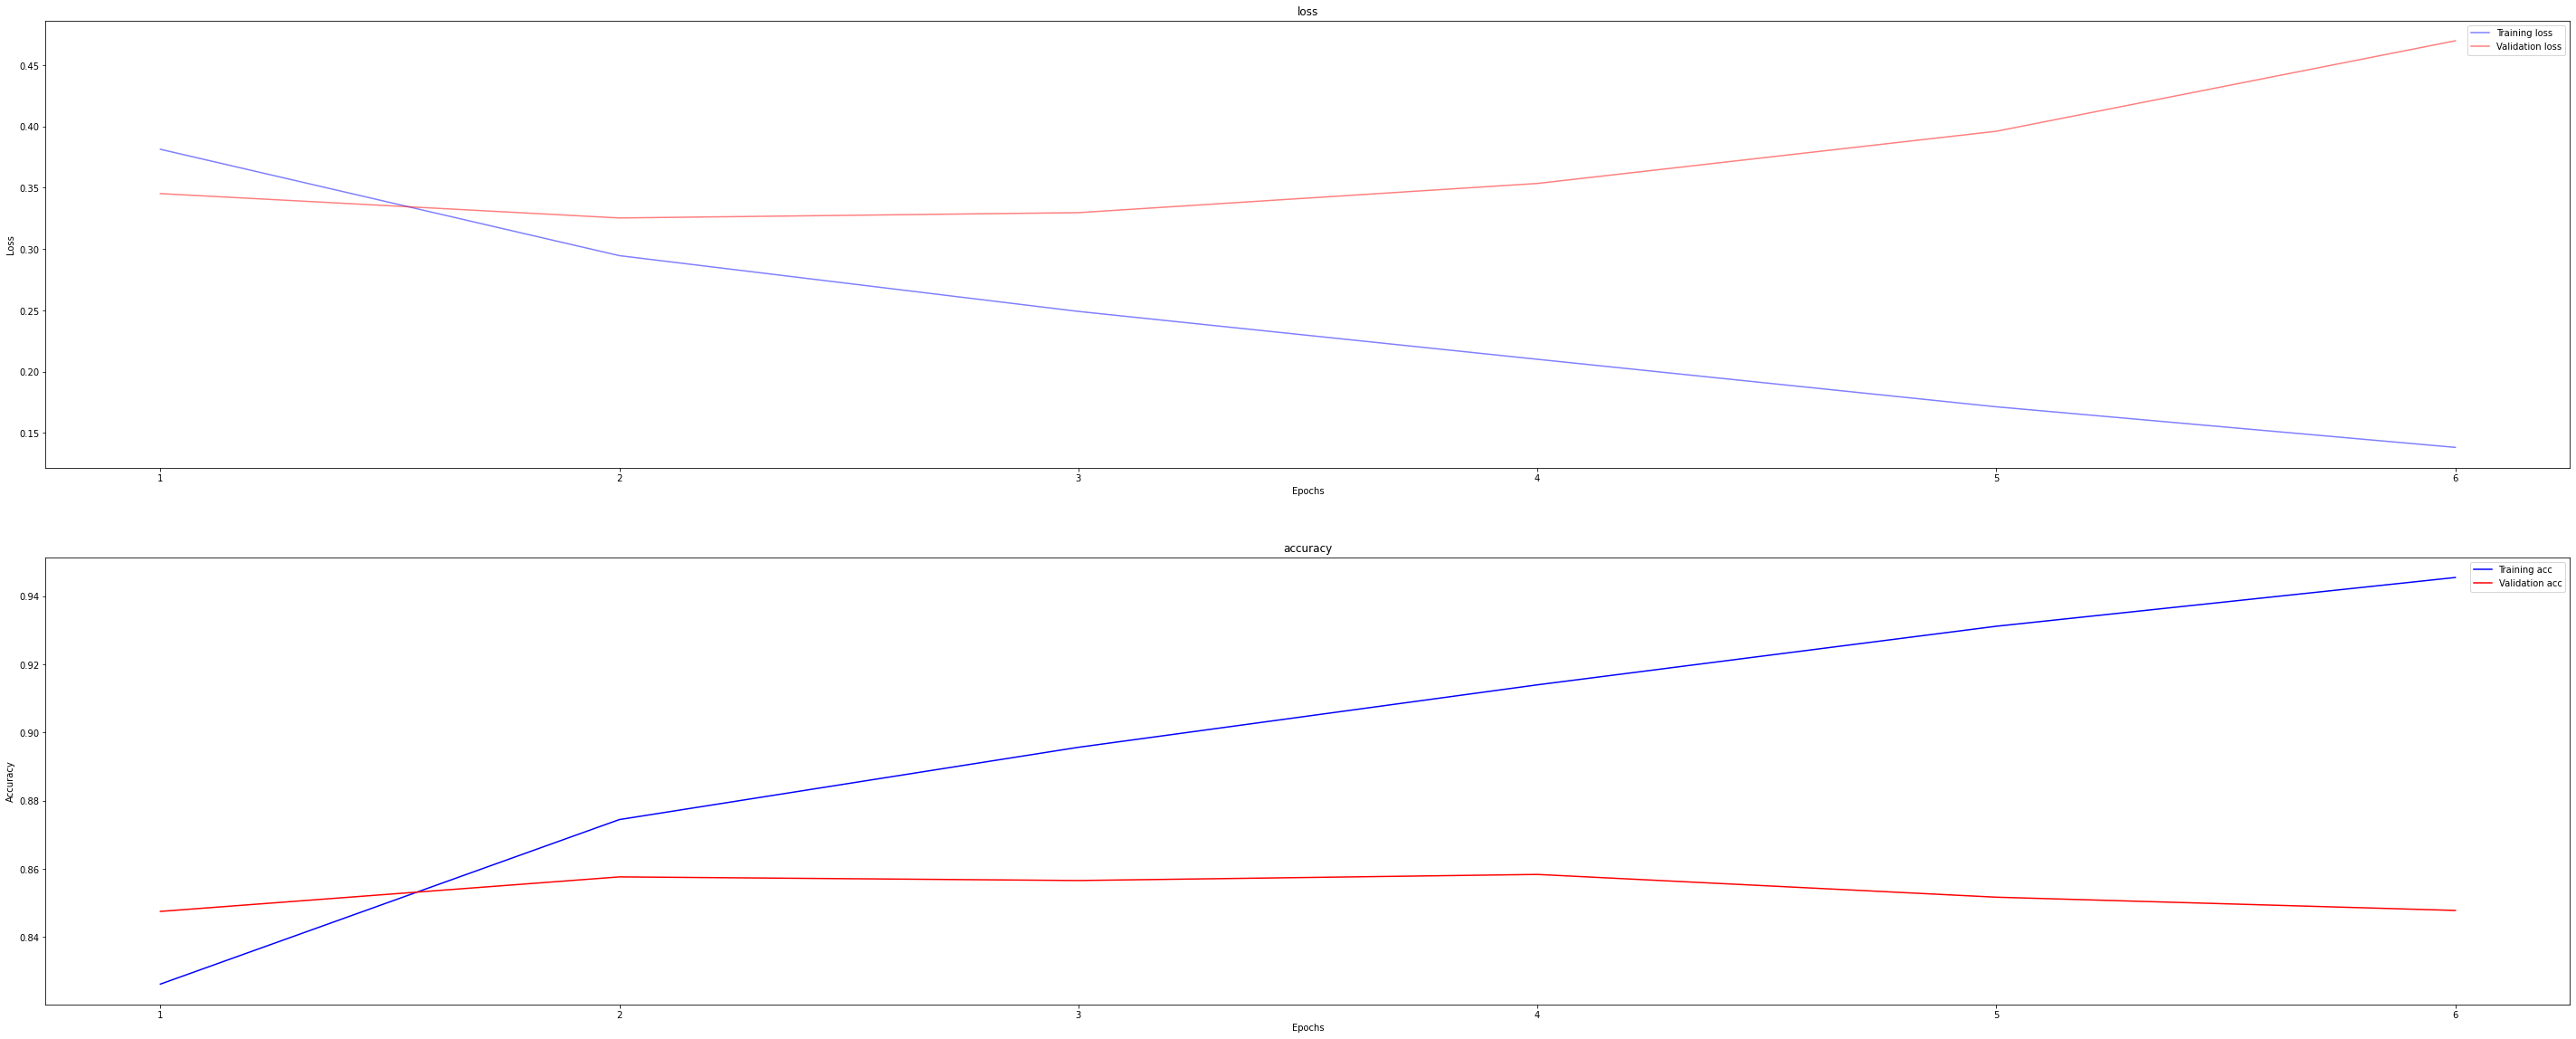

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(50, 20))

epochs = range(1, len(history.history['loss']) + 1)

ax[0].plot(epochs, history.history['loss'], 'b', alpha=0.5, label='Training loss')
ax[0].plot(epochs, history.history['val_loss'], 'r', alpha=0.5, label='Validation loss')
ax[0].set_title(f'loss')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(epochs, history.history['accuracy'], 'b', label='Training acc')
ax[1].plot(epochs, history.history['val_accuracy'], 'r', label='Validation acc')
ax[1].set_title(f'accuracy')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].legend()
    
plt.show()

In [25]:
model.evaluate(x_test, y_test, verbose=2)

799/799 - 2s - loss: 0.4668 - accuracy: 0.8483


[0.4667849540710449, 0.848261833190918]